This notebook applies the **`Parse`** step of the speech data processing pipeline.

![](https://cdn.discordapp.com/attachments/372491075153166338/1049274916106665985/2022-12-01_15-08-45.jpeg)

In [1]:
import os
import shutil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import torchaudio
from plotly.subplots import make_subplots
from plotly_resampler import FigureResampler
from tqdm.auto import tqdm

sys.path.append("..")
from IPython.display import Audio, display

from GSSP_utils.path_conf import interim_speech_data_dir, loc_data_dir

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
sns.set_context("talk")
# sns.set_style("whitegrid")

# https://pytorch.org/audio/stable/backend.html#module-torchaudio.backend
torchaudio.get_audio_backend()

from speechbrain.pretrained import VAD


torchvision is not available - cannot save figures


In [2]:
df_session = pd.read_parquet(loc_data_dir.joinpath("df_session_tot_cleaned.parquet"))

# load the model
VAD_model = VAD.from_hparams(
    source="speechbrain/vad-crdnn-libriparty", savedir=".vad_model"
)

# Load the outcome of the manual analysis script
df_analysis = pd.read_csv(loc_data_dir.joinpath("GSSP_manual_analysis.tsv"), sep="\t")
df_analysis["Retain after parsing"].value_counts()


YES       82
UNSURE     4
NO         3
Name: Retain after parsing, dtype: int64

## Slice the audio using the speechbrain VAD


In [3]:
sliced_vad_dir = interim_speech_data_dir.joinpath("VAD_slice_16khz")
margin_s = 0.25  # the margin in s between the first and last speech frame and the slice

df_session["VAD_sliced_duration_s"] = None
df_session["VAD_speech_start_s"] = None
df_session["VAD_speech_end_s"] = None


In [5]:
# shutil.rmtree(sliced_vad_dir, ignore_errors=True)

create_figure = False


In [13]:
retain_mask = df_analysis["Retain after parsing"] == "YES"

for _, retain_user in tqdm(
    list(df_analysis[retain_mask].iterrows()), total=retain_mask.sum()
):
    user_vis_dir = sliced_vad_dir / retain_user.ID

    # Iterate over all the audio files
    df_session_user = df_session[df_session.ID == retain_user.ID]
    assert len(df_session_user) > 0

    # Apply the VAD model on the audio data, create a visualization of it ad save the results
    df_session_user_v = df_session_user[df_session_user.wav_duration_s > 15]

    # print when the user has several audio files which arr too short
    if len(df_session_user_v) != len(df_session_user):
        print(df_session_user.shape[0], df_session_user_v.shape[0])

    for db in df_session_user_v.DB.unique():
        df_session_user_v_db = df_session_user_v[df_session_user_v.DB == db]
        user_vis_db_dir = user_vis_dir / {"Marloes": "marloes"}.get(db, db)
        os.makedirs(user_vis_db_dir, exist_ok=True)

        if create_figure:
            fig = FigureResampler(
                make_subplots(
                    rows=len(df_session_user_v_db),
                    cols=1,
                    shared_xaxes=False,
                    specs=[[{"secondary_y": True}]] * len(df_session_user_v_db),
                    vertical_spacing=0.2 / len(df_session_user_v_db),
                    subplot_titles=(
                        df_session_user_v_db.pic_name
                        + "__"
                        + df_session_user_v_db.time_str
                    ).values,
                )
            )
            fig.update_layout(height=200 * len(df_session_user_v_db))

        colors = px.colors.qualitative.Plotly
        for i, (df_idx, audio_file) in tqdm(enumerate(df_session_user_v_db.iterrows())):
            # continue
            npy_path = (
                interim_speech_data_dir
                / "full_dur_16khz"
                / audio_file.ID
                / {"Marloes": "marloes"}.get(audio_file.DB, audio_file.DB)
                / f"{audio_file.pic_name}__{audio_file.time_str}.npy"
            )
            arr_16khz = np.load(npy_path).ravel()
            t_arr_n = np.arange(len(arr_16khz)) / 16_000
            wav_path = npy_path.parent / (npy_path.stem + ".wav")

            # apply the VAD model to 16khz audio
            e2e_boundaries_tuning = (
                VAD_model.upsample_boundaries(
                    VAD_model.get_speech_segments(
                        audio_file=str(wav_path),
                        large_chunk_size=15,
                        small_chunk_size=1,
                        overlap_small_chunk=True,
                        apply_energy_VAD=True,
                        double_check=True,
                        # neural proba activation thresholds
                        activation_th=0.65,
                        deactivation_th=0.2,
                        # VAD energy activation thresholds
                        en_activation_th=0.6,
                        en_deactivation_th=0.3,
                    ),
                    audio_file=str(wav_path),
                )
                .numpy()
                .ravel()
            )

            # Add a rectangle where we would cut the audio
            where = np.where(e2e_boundaries_tuning > 0)[0]
            if not len(where):
                print(f"No speech detected in {wav_path}")
                continue
            else:
                speech_start_idx, speech_end_idx = where[0], where[-1]

            if create_figure:
                fig.add_trace(
                    go.Scattergl(name="16khz-wav", line_color=colors[0]),
                    hf_y=arr_16khz,
                    hf_x=t_arr_n,
                    max_n_samples=5_000,
                    col=1,
                    row=i + 1,
                )

                fig.add_trace(
                    go.Scattergl(name="VAD boundaries", line_color=colors[1]),
                    hf_y=e2e_boundaries_tuning,
                    hf_x=t_arr_n,
                    secondary_y=True,
                    col=1,
                    row=i + 1,
                )

                fig.add_vrect(
                    x0=0,
                    x1=max(0, t_arr_n[speech_start_idx] - margin_s),
                    line_width=0,
                    fillcolor="red",
                    opacity=0.2,
                    row=i + 1,
                    col=1,
                )
                fig.add_vrect(
                    x0=min(t_arr_n[-1], t_arr_n[speech_end_idx] + margin_s),
                    x1=t_arr_n[-1],
                    line_width=0,
                    fillcolor="red",
                    opacity=0.2,
                    row=i + 1,
                    col=1,
                )

            # slice the audio and save
            arr_vad_sliced = arr_16khz[
                max(0, int(speech_start_idx - margin_s * 16_000)) : min(
                    len(arr_16khz), int(speech_end_idx + margin_s * 16_000)
                )
            ]
            np.save(
                file=user_vis_db_dir / f"{audio_file.pic_name}__{audio_file.time_str}",
                arr=arr_vad_sliced,
            )
            np.save(
                file=user_vis_db_dir
                / f"VAD_{audio_file.pic_name}__{audio_file.time_str}",
                arr=e2e_boundaries_tuning,
            )

            df_session.at[df_idx, "VAD_sliced_duration_s"] = (
                len(arr_vad_sliced) / 16_000
            )
            df_session.at[df_idx, "VAD_speech_start_s"] = t_arr_n[speech_start_idx]
            df_session.at[df_idx, "VAD_speech_end_s"] = t_arr_n[speech_end_idx]

        if create_figure:
            # Save the figure
            fig.write_html(
                file=user_vis_db_dir.joinpath("VAD.html"), include_plotlyjs="cdn"
            )

del retain_mask


  0%|          | 0/82 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

37 36


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

37 34


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

No speech detected in /media/SPS/interim/speech_webapp/full_dur_16khz/1d259634-7d1a-461c-9098-5be8e94b105b/Radboud/Rafd090_36_Caucasian_male_neutral_frontal__19_15_05.wav


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

37 35


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

37 36


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

No speech detected in /media/SPS/interim/speech_webapp/full_dur_16khz/2e98e07d-5d7c-469b-aee1-2421856671b0/PiSCES/Picture 110__15_11_11.wav


0it [00:00, ?it/s]

No speech detected in /media/SPS/interim/speech_webapp/full_dur_16khz/2e98e07d-5d7c-469b-aee1-2421856671b0/Radboud/Rafd090_49_Caucasian_male_neutral_frontal__15_03_59.wav
No speech detected in /media/SPS/interim/speech_webapp/full_dur_16khz/2e98e07d-5d7c-469b-aee1-2421856671b0/Radboud/Rafd090_05_Caucasian_male_neutral_frontal__15_23_16.wav


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

15 13


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

37 35


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

37 35


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

No speech detected in /media/SPS/interim/speech_webapp/full_dur_16khz/63defe6b-db35-4b9c-b53d-90df6612beaa/Radboud/Rafd090_36_Caucasian_male_neutral_frontal__18_18_35.wav


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

37 35


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

37 36


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

37 35


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

37 34


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

37 32


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

37 35


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

37 13


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

37 36


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

37 36


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

37 36


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

37 36


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

No speech detected in /media/SPS/interim/speech_webapp/full_dur_16khz/d7fbc4b9-5f94-4639-b82b-6b1592b2ad3a/marloes/marloes__19_58_16.wav


0it [00:00, ?it/s]

No speech detected in /media/SPS/interim/speech_webapp/full_dur_16khz/d7fbc4b9-5f94-4639-b82b-6b1592b2ad3a/PiSCES/Picture 110__19_55_44.wav
No speech detected in /media/SPS/interim/speech_webapp/full_dur_16khz/d7fbc4b9-5f94-4639-b82b-6b1592b2ad3a/PiSCES/Picture 82__20_00_21.wav


0it [00:00, ?it/s]

No speech detected in /media/SPS/interim/speech_webapp/full_dur_16khz/d7fbc4b9-5f94-4639-b82b-6b1592b2ad3a/Radboud/Rafd090_24_Caucasian_male_neutral_frontal__19_59_13.wav
No speech detected in /media/SPS/interim/speech_webapp/full_dur_16khz/d7fbc4b9-5f94-4639-b82b-6b1592b2ad3a/Radboud/Rafd090_36_Caucasian_male_neutral_frontal__20_01_12.wav


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [14]:
df_session.to_parquet(loc_data_dir / "df_session_tot_cleaned_VAD.parquet")


## Analyze the sliced audio data 

In [19]:
from GSSP_utils.conf import color_palette

In [20]:
df_session = pd.read_parquet(loc_data_dir / "df_session_tot_cleaned_VAD.parquet")


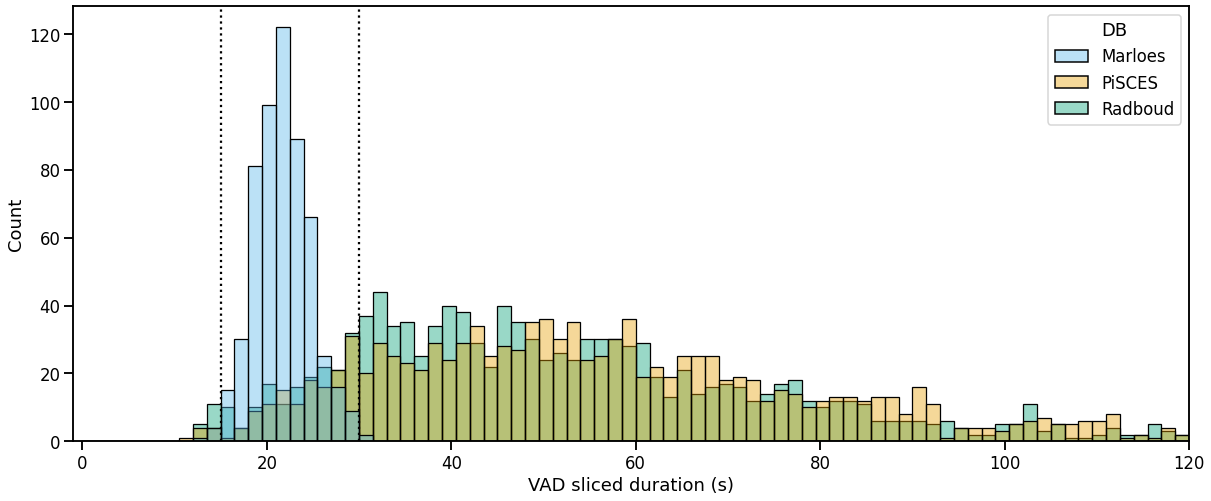

In [22]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.set_context("talk")
sns.histplot(
    data=df_session,
    hue="DB",
    x="VAD_sliced_duration_s",
    # palette="Set3",
    palette=color_palette[1:2] + color_palette[:1] + color_palette[2:3],
    ax=ax,
    alpha=0.4,
    bins=80,
    binrange=[0, 120],
)

ax.axvline(x=15, ls=":", c="black")
ax.axvline(x=30, ls=":", c="black")
ax.set_xlabel("VAD sliced duration (s)")
ax.set_xlim(-1, 120)
plt.show()


In [23]:
1 - sum((df_session.DB != 'Marloes') &(df_session.VAD_sliced_duration_s < 30)) / sum(df_session.DB != 'Marloes')

0.8772727272727273

In [24]:
sum(df_session['VAD_sliced_duration_s'] < 15)

30

### Speech start offset

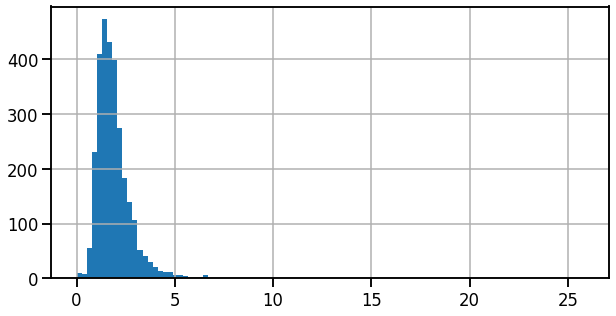

In [25]:
df_session["VAD_speech_start_s"].dropna().hist(figsize=(10, 5), bins=100)
plt.show()


Listen to an audio sample with a large speech start offset

In [21]:
r = df_session[df_session.VAD_speech_start_s > 8].sample(1).iloc[0]
display(r.to_frame().T)
arr_path = (
    interim_speech_data_dir
    / "full_dur_16khz"
    / r.ID
    / r.DB
    / f"{r.pic_name}__{r.time_str}.npy"
)
Audio(data=np.load(arr_path).ravel()[: 15 * 16_000], rate=16_000)


,age,education,sex,timestamp,ID,Marloes,PiSCES,Radboud,device,prolific_token,pic_name,time_str,wav_size,wav_sample_rate,wav_duration_s,wav_timestamp,DB,arousal,valence,DB_no,session_no,pic_no,pic_count,VAD_sliced_duration_s,VAD_speech_start_s,VAD_speech_end_s,VAD_end_offset
1024,21,ho,female,2022-07-17 20:35:07.311172+02:00,5307991a-b2cd-46b6-a925-3bb998e34da7,7,15,15,pc-mic,n.a.,Rafd090_57_Caucasian_female_neutral_frontal,21:13:31,13934636,48000,145.15,2022-07-17 21:13:38+02:00,Radboud,19,93,5,12,10.0,1.0,135.199938,8.679937,143.379875,1.770125


### Speech end offset

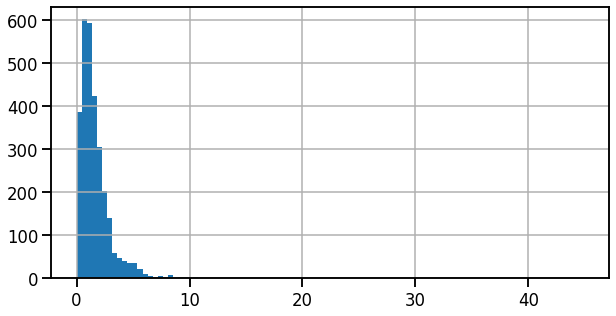

In [26]:
df_session["VAD_end_offset"] = (
    df_session["wav_duration_s"] - df_session["VAD_speech_end_s"]
)

df_session.VAD_end_offset.dropna().hist(figsize=(10, 5), bins=100)
plt.show()


Listen to some audio files with a large audio end offset (meaning that there is a lot of silence at the end of the audio files)

In [27]:
df_session[(df_session.VAD_end_offset > 10)]


,age,education,sex,timestamp,ID,Marloes,PiSCES,Radboud,device,prolific_token,pic_name,time_str,wav_size,wav_sample_rate,wav_duration_s,wav_timestamp,DB,arousal,valence,DB_no,session_no,pic_no,VAD_sliced_duration_s,VAD_speech_start_s,VAD_speech_end_s,VAD_end_offset
1589,29,unif,male,2020-12-07 19:47:48.102483+01:00,8f42a931-7bd1-4536-bec3-a5f24da3c61f,7,15,15,pc-mic,None,Rafd090_36_Caucasian_male_neutral_frontal,20:24:50,4685868,48000,48.81,2020-12-07 20:24:50+01:00,Radboud,50,50,9,22,18.0,31.689937,2.970000,34.159937,14.650063
2530,21,unif,female,2022-06-27 16:35:06.603373+02:00,c01ce6ad-27c2-4d41-828a-37f51cc33ba0,7,15,15,headset,60bce8474b590baeb84b6cdd,Rafd090_02_Caucasian_female_neutral_frontal,16:51:13,7569452,48000,78.85,2022-06-27 16:51:10+02:00,Radboud,4,63,2,5,4.0,61.239938,2.080000,62.819938,16.030062
2531,21,unif,female,2022-06-27 16:35:06.603373+02:00,c01ce6ad-27c2-4d41-828a-37f51cc33ba0,7,15,15,headset,60bce8474b590baeb84b6cdd,Picture 81,16:52:46,7356460,48000,76.63,2022-06-27 16:52:44+02:00,PiSCES,27,93,3,6,5.0,64.709937,1.850000,66.059938,10.570062
2535,21,unif,female,2022-06-27 16:35:06.603373+02:00,c01ce6ad-27c2-4d41-828a-37f51cc33ba0,7,15,15,headset,60bce8474b590baeb84b6cdd,Rafd090_57_Caucasian_female_neutral_frontal,16:58:39,8544300,48000,89.00,2022-06-27 16:58:36+02:00,Radboud,29,40,4,10,8.0,73.899937,2.270000,75.669938,13.330062
2555,21,unif,female,2022-06-27 16:35:06.603373+02:00,c01ce6ad-27c2-4d41-828a-37f51cc33ba0,7,15,15,headset,60bce8474b590baeb84b6cdd,Picture 118,17:30:24,10403884,48000,108.37,2022-06-27 17:30:22+02:00,PiSCES,36,58,13,30,25.0,62.699875,1.250000,63.449875,44.920125
2765,39,ho,female,2022-06-29 19:34:02.048344+02:00,d7fbc4b9-5f94-4639-b82b-6b1592b2ad3a,7,15,15,pc-mic,n.a.,Picture 80,19:57:47,5701676,48000,59.39,2022-06-29 19:57:48+02:00,PiSCES,63,64,8,18,15.0,18.909938,11.590000,29.999938,29.390062
2825,20,so,male,2022-07-26 21:46:34.776329+02:00,e03516f6-1af7-4c72-ad49-41b6db4733d7,7,15,15,pc-mic,5f58064bbb4b673607a4c7f4,Picture 105,21:57:32,4300844,48000,44.80,2022-07-26 21:57:32+02:00,PiSCES,35,62,2,4,3.0,31.799875,1.460000,32.759875,12.040125
2845,20,so,male,2022-07-26 21:46:34.776329+02:00,e03516f6-1af7-4c72-ad49-41b6db4733d7,7,15,15,pc-mic,5f58064bbb4b673607a4c7f4,Rafd090_61_Caucasian_female_neutral_frontal,22:22:37,3760172,48000,39.17,2022-07-26 22:22:38+02:00,Radboud,69,56,10,24,20.0,27.769938,1.569937,28.839875,10.330125


In [28]:
r = (
    df_session[
        (df_session.ID == "e03516f6-1af7-4c72-ad49-41b6db4733d7")
        & (df_session.time_str == "21:57:32")
    ]
    .sample(1)
    .iloc[0]
)
display(r.to_frame().T)
arr_path = (
    interim_speech_data_dir
    / "full_dur_16khz"
    / r.ID
    / r.DB
    / f"{r.pic_name}__{r.time_str}.npy"
)
Audio(data=np.load(arr_path).ravel()[30 * 16_000: 45 * 16_000], rate=16_000)


,age,education,sex,timestamp,ID,Marloes,PiSCES,Radboud,device,prolific_token,pic_name,time_str,wav_size,wav_sample_rate,wav_duration_s,wav_timestamp,DB,arousal,valence,DB_no,session_no,pic_no,VAD_sliced_duration_s,VAD_speech_start_s,VAD_speech_end_s,VAD_end_offset
2825,20,so,male,2022-07-26 21:46:34.776329+02:00,e03516f6-1af7-4c72-ad49-41b6db4733d7,7,15,15,pc-mic,5f58064bbb4b673607a4c7f4,Picture 105,21:57:32,4300844,48000,44.8,2022-07-26 21:57:32+02:00,PiSCES,35,62,2,4,3.0,31.799875,1.46,32.759875,12.040125
